# Proportion analysis and DE scoring
## Load libraries and data

In [1]:
import sys
import os
os.environ['R_HOME'] = '/home/lfaure/miniconda3/envs/bulk/lib/R/'
import scanpy as sc
import numpy as np
import pandas as pd
import anndata2ri
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
import deseq2py as deseq2
sc.set_figure_params()

### Get bulk data

### Get ML10 dataset

In [2]:
from load_gpu import read_mtx_gpu
import pandas as pd

In [3]:
adata=read_mtx_gpu("../../ML8-11/raw/matrix.mtx").T
adata.obs_names=pd.read_csv("../../ML8-11/raw/barcodes.tsv",header=None)[0].values
adata.var_names=pd.read_csv("../../ML8-11/raw/features.tsv",header=None)[0].values

Getting mtx
    loading to device
    transfering to host and converting to anndata


In [4]:
adata.obs["sampl"]=[s[0] for s in adata.obs_names.str.split("_")]


In [5]:
adata.obs["leiden"]=pd.read_csv("../leiden_assigned.csv")["leiden"].values
adata.obs["leiden"]=adata.obs["leiden"].astype("category")
adata[adata.obs.sampl=="ML10"].obs.leiden.value_counts()

OF     6542
PS2    3615
OR     3452
ZL     2880
PS1    2065
ON     1931
FB      754
NSC     477
ME      475
B       401
EE      278
PD      144
NCC      22
PO        7
Name: leiden, dtype: int64

In [6]:
adata=adata[adata.obs.sampl=="ML10"]
#adata=adata[adata.obs.leiden!="NCC"]


In [7]:
adata

View of AnnData object with n_obs × n_vars = 23043 × 20201
    obs: 'sampl', 'leiden'

## Proportion analysis

In [8]:
import seaborn as sns
import scvelo as scv
def plot_prop(mat_prop,title="",return_df=False):
    scv.set_figure_params(figsize=(4,4),dpi=150)
    toplot=mat_prop.reset_index().melt(id_vars="index")
    toplot["cond"]=[s[0] for s in toplot["index"]]
    toplot.cond=toplot.cond.replace(["C","M"],["Control","Mutant"])
    ax=sns.stripplot(y="variable",x="value",hue="cond",
                     palette=["tab:blue","tab:orange"],
                     data=toplot)
    ax.set_ylabel("10X leiden cluster at E10")
    ax.set_xlabel("inferred bulk proportion")
    ax.set_title(title)
    if return_df:
        return toplot

In [9]:
adata_bulk=sc.read("adata_bulk_star.h5ad")

### Run rnas-sieve

In [10]:
common=np.intersect1d(adata_bulk.var_names,adata.var_names)

adata=adata[:,common]
adata_bulk=adata_bulk[:,common]

In [11]:
counts_by_leiden=dict(zip(adata.obs.leiden.cat.categories,
         [adata[adata.obs.leiden==l].X.T.A for l in adata.obs.leiden.cat.categories]))

In [12]:
psis=np.array(adata_bulk.X.T)

In [13]:
from rnasieve.preprocessing import model_from_raw_counts
model, cleaned_psis = model_from_raw_counts(counts_by_leiden, psis)

In [14]:
res=model.predict(cleaned_psis)
res.index=adata_bulk.obs_names

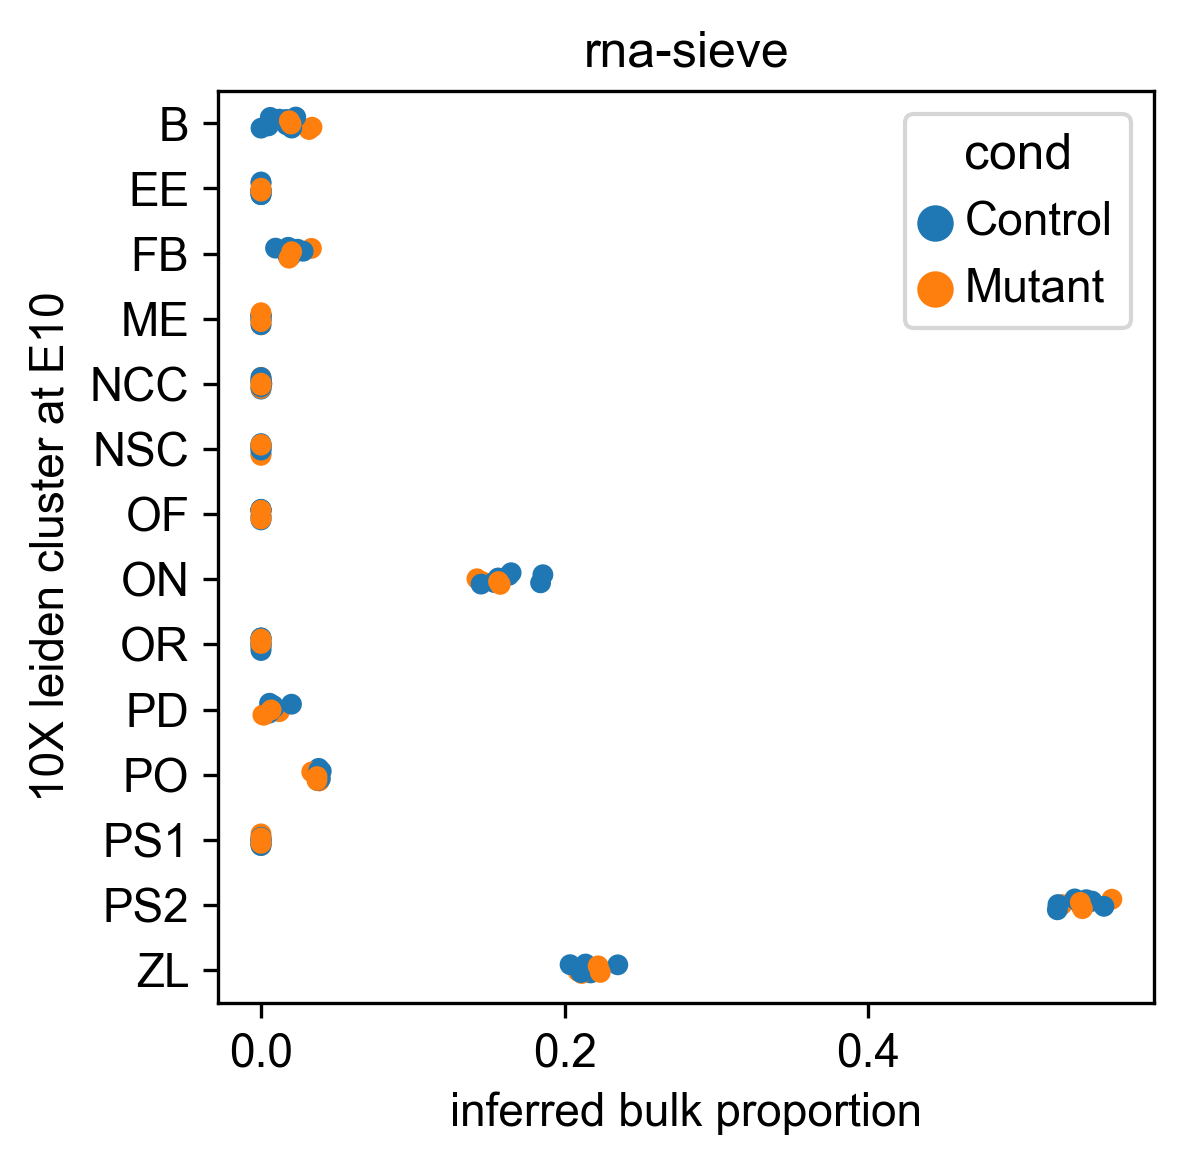

In [15]:
toplot=plot_prop(res,"rna-sieve",return_df=True)

In [16]:
from scipy.stats import ttest_ind
ttest_ind(toplot.loc[(toplot.variable=="B") & (toplot.cond=="Control")].value,
          toplot.loc[(toplot.variable=="B") & (toplot.cond=="Mutant")].value)

Ttest_indResult(statistic=-2.7428382475449244, pvalue=0.02073151175576071)

### loading ML10

In [133]:
adata=read_mtx_gpu("../../ML10/matrix.mtx.gz").T
adata.obs_names=pd.read_csv("../../ML10/barcodes.tsv.gz",header=None)[0].values
adata.var_names=pd.read_table("../../ML10/features.tsv.gz",header=None)[1].values

Getting mtx
    loading to device
    transfering to host and converting to anndata


In [134]:
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)

In [135]:
adata.obs_names="ML10_"+adata.obs_names

In [136]:
PCA=pd.read_csv("../../ML8-11/PCA.csv",index_col=0)

In [137]:
PCA=PCA.loc[PCA.index.str.startswith("ML10")]

In [138]:
adata=adata[PCA.index]

In [139]:
umap=pd.read_csv("../../ML10/UMAP_ML10.csv",index_col=0)
adata.obsm["X_umap"]=umap.loc[adata.obs_names].values
adata.obsm["X_pca"]=PCA.loc[adata.obs_names].values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [140]:
sc.pp.neighbors(adata,n_neighbors=50)

In [141]:
adata.obs

Empty DataFrame
Columns: []
Index: [ML10_AAACCCAAGTACTCGT-1, ML10_AAACCCAAGTCTGGAG-1, ML10_AAACCCACAACAAAGT-1, ML10_AAACCCACACCGTGAC-1, ML10_AAACCCACACCGTGGT-1, ML10_AAACCCACAGCAGTTT-1, ML10_AAACCCACATGCAGGA-1, ML10_AAACCCAGTAATACCC-1, ML10_AAACCCAGTATGTCCA-1, ML10_AAACCCAGTCGAAACG-1, ML10_AAACCCAGTGGGTATG-1, ML10_AAACCCAGTGGGTCAA-1, ML10_AAACCCAGTTCCTAGA-1, ML10_AAACCCAGTTCTCGTC-1, ML10_AAACCCAGTTGGGTAG-1, ML10_AAACCCAGTTGTCTAG-1, ML10_AAACCCATCAAGCCCG-1, ML10_AAACCCATCAAGCTTG-1, ML10_AAACCCATCACCTGGG-1, ML10_AAACCCATCACTAGCA-1, ML10_AAACCCATCCATTCAT-1, ML10_AAACCCATCCGCGAGT-1, ML10_AAACCCATCCGCGGAT-1, ML10_AAACCCATCCTGTACC-1, ML10_AAACCCATCGCTACGG-1, ML10_AAACCCATCGGAAGGT-1, ML10_AAACCCATCTCGCAGG-1, ML10_AAACCCATCTGCACCT-1, ML10_AAACCCATCTGCTGAA-1, ML10_AAACCCATCTTAGGAC-1, ML10_AAACCCATCTTCGATT-1, ML10_AAACGAAAGCGATGAC-1, ML10_AAACGAAAGGGACAGG-1, ML10_AAACGAAAGTATAGGT-1, ML10_AAACGAAAGTCCTGCG-1, ML10_AAACGAAAGTCTACCA-1, ML10_AAACGAAAGTTACTCG-1, ML10_AAACGAAAGTTTCGGT-1, ML10_AAACGAACAAGCTACT-1, ML10_AAACGAACACAGGATG-1, ML10_AAACGAACAGAACCGA-1, ML10_AAACGAACAGATCCTA-1, ML10_AAACGAACAGTGTACT-1, ML10_AAACGAACATAGATGA-1, ML10_AAACGAACATCCGATA-1, ML10_AAACGAACATGGTGGA-1, ML10_AAACGAAGTAACATAG-1, ML10_AAACGAAGTACATACC-1, ML10_AAACGAAGTACGCTAT-1, ML10_AAACGAAGTCGAACAG-1, ML10_AAACGAAGTGGAGAAA-1, ML10_AAACGAAGTGGCTAGA-1, ML10_AAACGAAGTGGTCCCA-1, ML10_AAACGAAGTGTCATGT-1, ML10_AAACGAAGTTCCACGG-1, ML10_AAACGAAGTTCCTTGC-1, ML10_AAACGAAGTTGGTAGG-1, ML10_AAACGAATCCCATAAG-1, ML10_AAACGAATCGTTATCT-1, ML10_AAACGAATCTATGCCC-1, ML10_AAACGAATCTTTGGAG-1, ML10_AAACGCTAGGCATCTT-1, ML10_AAACGCTAGGTGCCAA-1, ML10_AAACGCTAGTAGGCCA-1, ML10_AAACGCTCAAGAGTAT-1, ML10_AAACGCTCAAGCGCAA-1, ML10_AAACGCTCAAGGTACG-1, ML10_AAACGCTCACCTGATA-1, ML10_AAACGCTCAGCAGGAT-1, ML10_AAACGCTCAGGGTCTC-1, ML10_AAACGCTCAGTCAGTT-1, ML10_AAACGCTCAGTCGGTC-1, ML10_AAACGCTCATGAAGCG-1, ML10_AAACGCTCATTGCAAC-1, ML10_AAACGCTGTATGAGGC-1, ML10_AAACGCTGTCACGTGC-1, ML10_AAACGCTGTCCTTTGC-1, ML10_AAACGCTGTGAATAAC-1, ML10_AAACGCTGTGGCTCTG-1, ML10_AAACGCTTCAACCGAT-1, ML10_AAACGCTTCACCTCTG-1, ML10_AAACGCTTCATGAAAG-1, ML10_AAACGCTTCATTTGTC-1, ML10_AAACGCTTCGGTATGT-1, ML10_AAACGCTTCGTAGTCA-1, ML10_AAACGCTTCTCTCTTC-1, ML10_AAACGCTTCTGGCTGG-1, ML10_AAACGCTTCTTTGATC-1, ML10_AAAGAACAGACTCAAA-1, ML10_AAAGAACAGCGGGTTA-1, ML10_AAAGAACAGCGGTATG-1, ML10_AAAGAACAGGCCTGCT-1, ML10_AAAGAACAGGTAAAGG-1, ML10_AAAGAACAGGTGCTTT-1, ML10_AAAGAACAGTAACCTC-1, ML10_AAAGAACAGTATTAGG-1, ML10_AAAGAACAGTTAGTAG-1, ML10_AAAGAACAGTTGTAGA-1, ML10_AAAGAACCAAGAAACT-1, ML10_AAAGAACCACAACGCC-1, ...]

[23043 rows x 0 columns]

In [142]:
adata.obs["leiden"]=pd.read_csv("../leiden_assigned.csv",index_col=0).loc[adata.obs_names].values
adata.obs["leiden"]=adata.obs["leiden"].astype("category")

In [143]:
lcol=pd.read_csv("../leiden_colors.csv",index_col=0)

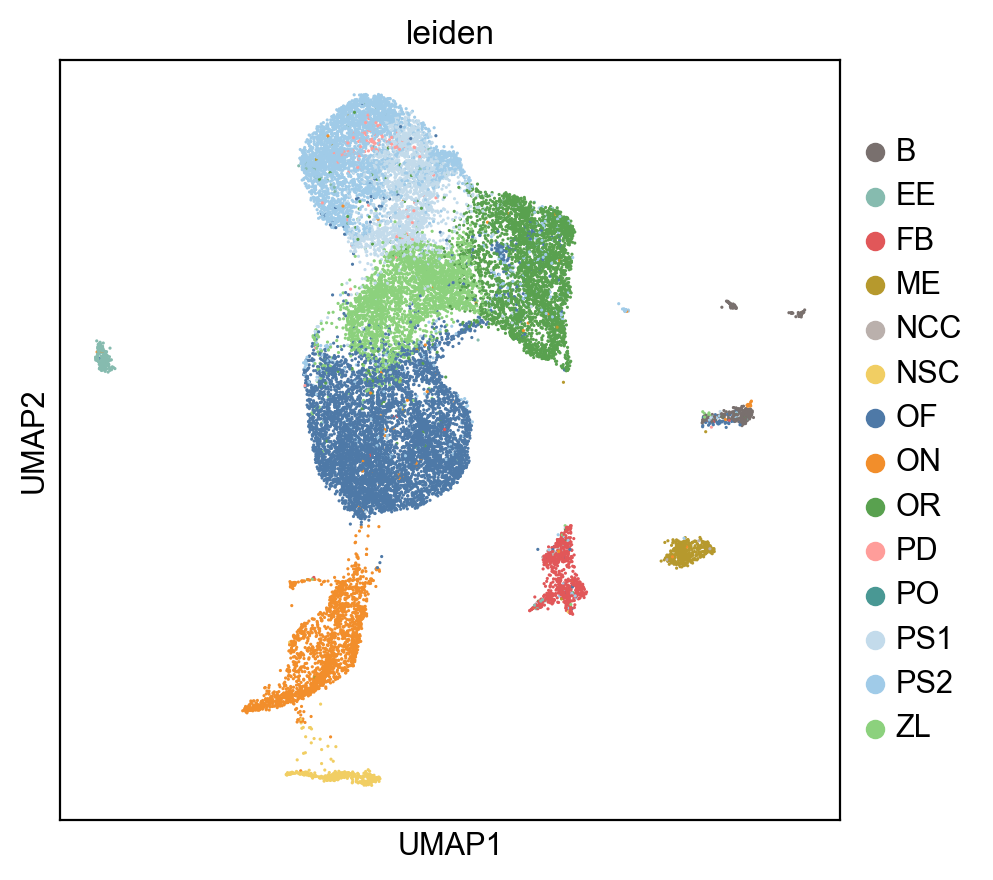

In [144]:
adata.uns["leiden_colors"]=lcol.loc[adata.obs["leiden"].cat.categories]["0"].values
sc.pl.umap(adata,color="leiden")


In [145]:
DE_res=pd.read_csv("DESEQ2.csv",index_col=0)
DE_res=DE_res.loc[DE_res.padj<0.05]
DE_res=DE_res.loc[DE_res.log2FoldChange.abs().sort_values(ascending=False).index]

In [146]:
sc.tl.rank_genes_groups(adata,"leiden")

In [147]:
DE_all=sc.get.rank_genes_groups_df(adata,["PS1","PS2","OR","OF","ZL","OR"],pval_cutoff=0.05,log2fc_min=.5).set_index("names")


In [148]:
DE_all

group     scores  logfoldchanges          pvals      pvals_adj
names                                                                       
Wnt6            PS1  55.017174        1.612322   0.000000e+00   0.000000e+00
Sostdc1         PS1  51.653130        2.000009   0.000000e+00   0.000000e+00
Pdlim1          PS1  48.988091        1.508977   0.000000e+00   0.000000e+00
Tfap2b          PS1  42.364677        1.660702  3.117606e-292  3.795076e-289
Wnt4            PS1  41.420509        1.514493  1.210312e-280  1.168493e-277
...             ...        ...             ...            ...            ...
Rassf6           ZL   2.401392        0.987828   1.638927e-02   4.798356e-02
Cacna1g          ZL   2.392791        1.000066   1.677828e-02   4.899440e-02
Pou5f2           ZL   2.390225        0.637145   1.689365e-02   4.930558e-02
2810414N06Rik    ZL   2.389448        0.790693   1.692998e-02   4.939890e-02
Kif17            ZL   2.388997        1.362857   1.695285e-02   4.944743e-02

[4406 rows x 5 columns]

In [149]:
DE_all=DE_all.loc[DE_all.index.isin(DE_res.index)]
DE_all=DE_all.loc[DE_all.index]
DE_all=DE_all.sort_values("logfoldchanges")
DE_all=DE_all.reset_index()
DE_all=DE_all.drop_duplicates("names",keep="first").set_index("names")

In [150]:
DE_res["leiden"]=np.nan
DE_res.loc[DE_all.index,"leiden"]=DE_all.group

In [151]:
DE_res2=DE_res.loc[~DE_res.leiden.isna()]

In [152]:
CC_res=DE_res2.loc[(DE_res2.log2FoldChange>0)]
M_res=DE_res2.loc[(DE_res2.log2FoldChange<0)]

In [153]:
CC_res

baseMean  log2FoldChange     lfcSE        pvalue          padj  \
Geneid                                                                       
Gjb2     1979.567428        3.048407  0.449324  5.413701e-13  3.570218e-10   
Gjb6      726.914608        2.788985  0.532077  6.518075e-09  1.432843e-06   
Mfap5      27.757733        2.575944  0.444214  3.477257e-10  1.034187e-07   
Krt15    1791.154733        1.965145  0.371360  6.019947e-09  1.342802e-06   
Gabra1    124.826443        1.803751  0.269689  1.088404e-12  6.737796e-10   
...              ...             ...       ...           ...           ...   
Pdgfc   18565.072746        0.180657  0.076133  2.276217e-03  4.472236e-02   
Ypel1    3754.380181        0.173698  0.063116  8.991410e-04  2.439744e-02   
Zbtb34   2277.082932        0.169617  0.067642  1.824994e-03  3.898298e-02   
Isl1     2050.974543        0.166427  0.065945  1.827327e-03  3.898298e-02   
Lmo4     8689.315380        0.146218  0.058896  2.599225e-03  4.837429e-02   

       leiden  
Geneid         
Gjb2       ZL  
Gjb6      PS2  
Mfap5     PS2  
Krt15      ZL  
Gabra1    PS2  
...       ...  
Pdgfc     PS2  
Ypel1      ZL  
Zbtb34    PS1  
Isl1       OR  
Lmo4       ZL  

[163 rows x 6 columns]

In [155]:
import scFates as scf
adata.var_names_make_unique()
sc.pp.filter_genes(adata,min_cells=1)
scf.pp.find_overdispersed(adata)
adata.obsm["X_pca"]=sc.pp.pca(sc.pp.scale(adata[:,adata.var.highly_variable].X,copy=True))
sc.pp.neighbors(adata,n_neighbors=50,n_pcs=20)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 1787 over-dispersed features (0:00:03) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



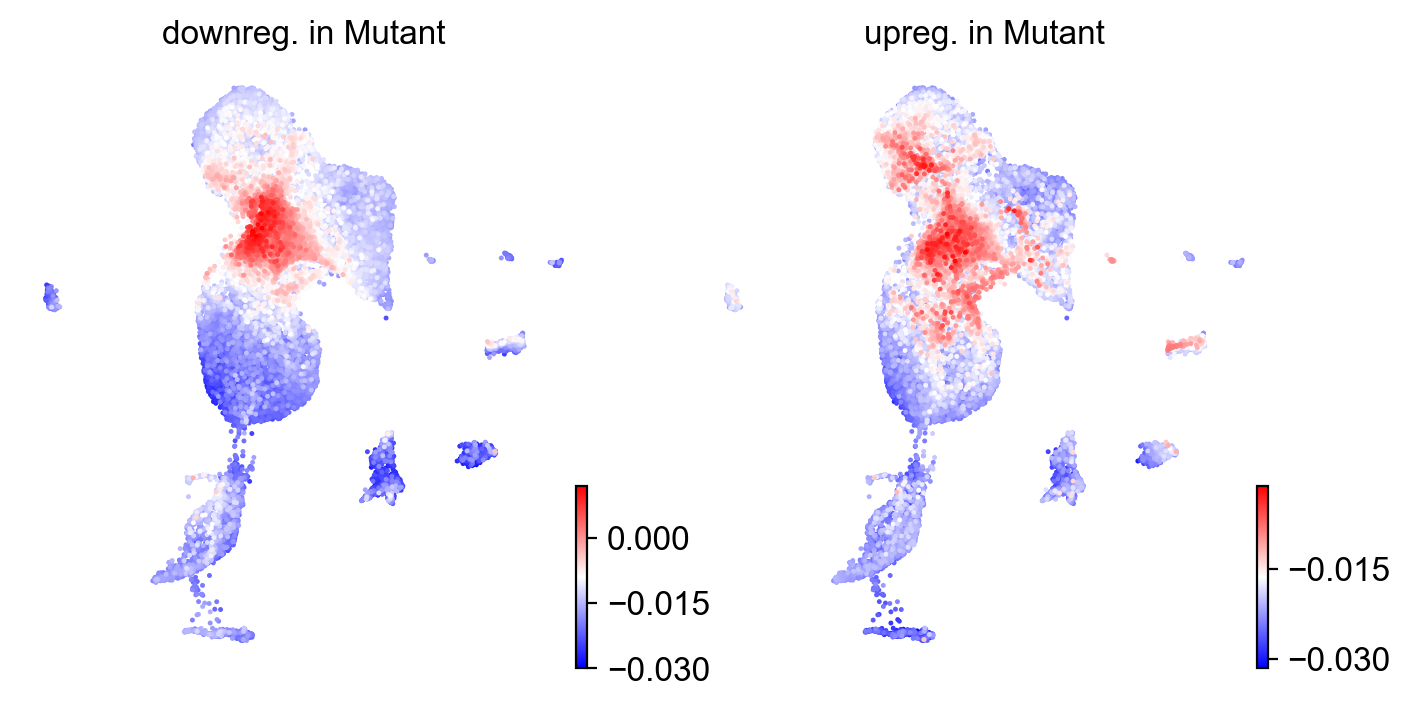

In [162]:
scf.set_figure_pubready()

scv.set_figure_params(figsize=(5,5))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
sc.tl.score_genes(adata,gene_list=M_res.index,
                  score_name="upreg. in Mutant")
scv.pl.umap(adata,color="downreg. in Mutant",ax=ax1,show=False,
            cmap="bwr",smooth=True)
sc.tl.score_genes(adata,gene_list=CC_res.index,
                  score_name="downreg. in Mutant")

scv.pl.umap(adata,color="upreg. in Mutant",ax=ax2,show=False,
            cmap="bwr",smooth=True)
plt.savefig("DE_scoring.pdf",dpi=600)

In [72]:
upreg=DE_res.index[DE_res.log2FoldChange>1]

In [52]:
adata.var_names_make_unique()

In [53]:
sc.tl.score_genes(adata,upreg,score_name="upreg")

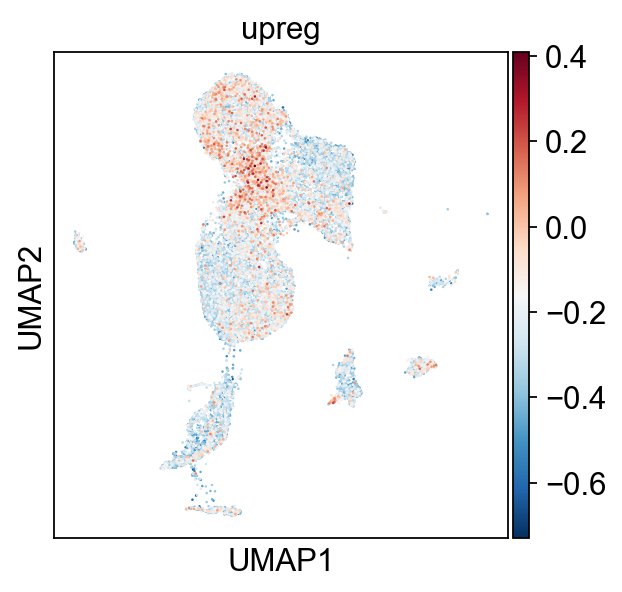

In [54]:
sc.pl.umap(adata,color="upreg")

In [80]:
sc.pp.neighbors(adata,n_neighbors=50,use_rep="X_umap")

In [81]:
sc.tl.leiden(adata,key_added="nleiden",resolution=.2)

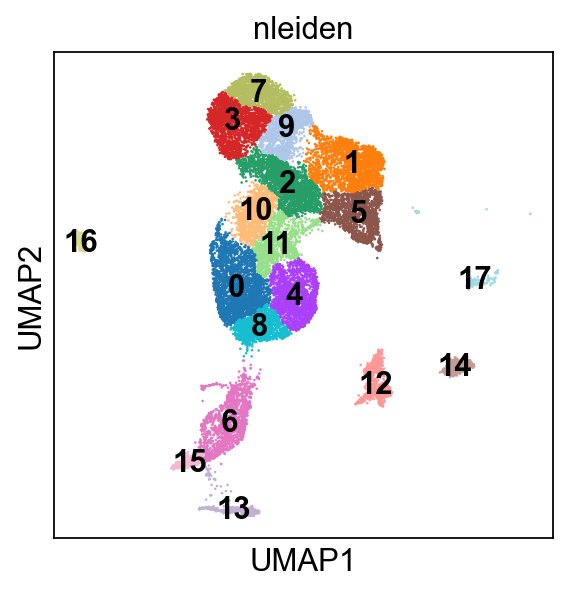

In [83]:
sc.pl.umap(adata,color="nleiden",legend_loc="on data")

In [84]:
adata=adata[adata.obs.nleiden!="17"]

In [85]:
sc.pp.neighbors(adata,n_neighbors=50,n_pcs=20)

In [86]:
conn=adata.obsp["connectivities"]
conn.setdiag(1)
conn = conn.multiply(1.0 / conn.sum(1))

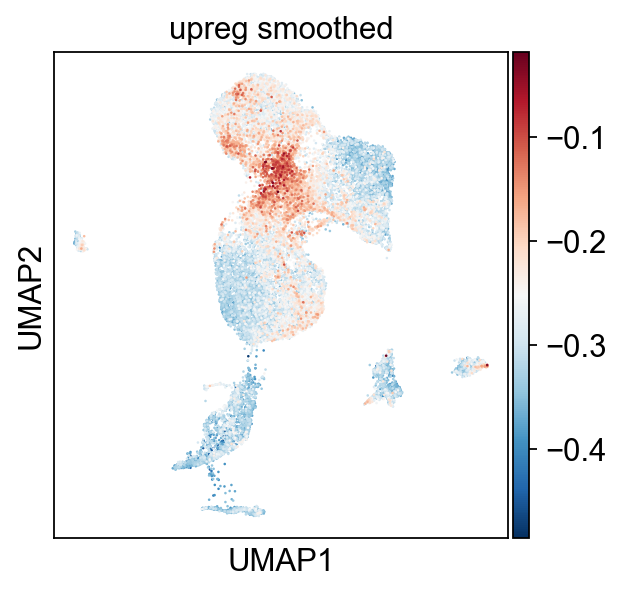

In [87]:
adata.obs["upreg smoothed"]=conn.dot(adata.obs["upreg"])
sc.pl.umap(adata,color="upreg smoothed")

In [108]:
downreg=DE_res.index[DE_res.log2FoldChange<-.5]

In [109]:
downreg

Index(['Pax5', 'En2', 'Olfr430', 'Wnt8a', 'Bod1-ps', 'Hapln1', 'Gdnf',
       'Slc26a7', 'Gm8983', 'Tgm2',
       ...
       'Vgll3', 'Kctd12b', 'Cspg4', 'Nr2f1', 'Fgf10', 'Slc4a5', 'Arhgef6',
       'Wnk4', 'Serpinb6b', 'Gpm6a'],
      dtype='object', name='Geneid', length=125)

In [110]:
sc.tl.score_genes(adata,downreg,score_name="downreg")

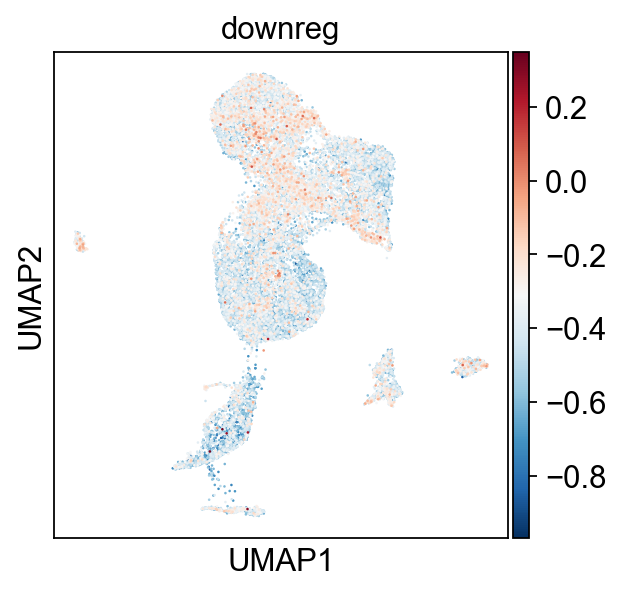

In [111]:
sc.pl.umap(adata,color="downreg")

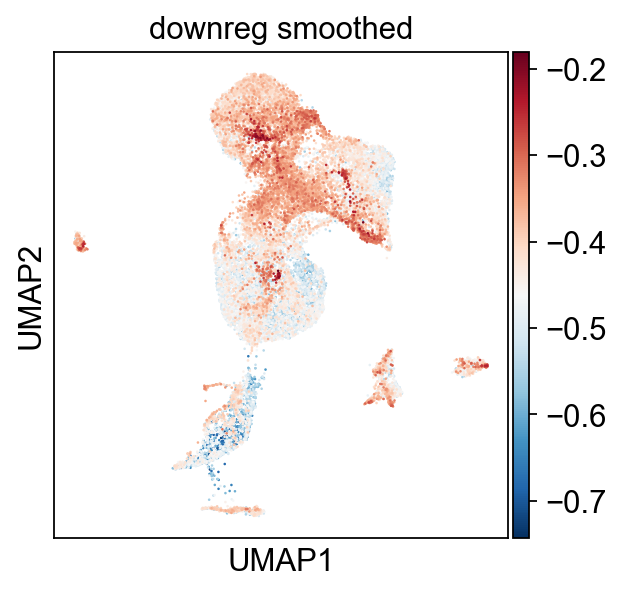

In [112]:
adata.obs["downreg smoothed"]=conn.dot(adata.obs["downreg"])
sc.pl.umap(adata,color="downreg smoothed")

In [26]:
import scFates as scf

In [27]:
sc.pp.filter_genes(adata,min_cells=1)
scf.pp.find_overdispersed(adata)
adata.obsm["X_pca"]=sc.pp.pca(sc.pp.scale(adata[:,adata.var.highly_variable].X,copy=True))
sc.pp.neighbors(adata,n_neighbors=50,n_pcs=20)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 1787 over-dispersed features (0:00:04) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



In [28]:
DE_res=DE_res.loc[DE_res.padj<0.05]
DE_res=DE_res.loc[DE_res.log2FoldChange.abs().sort_values(ascending=False).index]

In [29]:
CC=DE_res.index[(DE_res.log2FoldChange>0)]
M=DE_res.index[(DE_res.log2FoldChange<0)]

In [30]:
DE_res

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
Geneid                                                                    
Gjb2      1979.567428        3.172278  0.439709  7.214489  5.413701e-13   
Adcy8       62.977115        3.168130  0.966628  3.277505  1.047288e-03   
Tlx1        41.793439        3.060296  0.338729  9.034650  1.645283e-19   
Gjb6       726.914608        2.976166  0.512876  5.802892  6.518075e-09   
Mfap5       27.757733        2.720252  0.433447  6.275852  3.477257e-10   
...               ...             ...       ...       ...           ...   
Cnot1    17162.353932       -0.172586  0.051841 -3.329120  8.712071e-04   
Sdha     11284.494635       -0.171910  0.052532 -3.272506  1.065987e-03   
Chd8      8744.238676       -0.171033  0.056318 -3.036884  2.390375e-03   
Vgll4     7135.605217        0.164201  0.052714  3.114950  1.839762e-03   
Marchf6  10016.563789       -0.159764  0.046848 -3.410280  6.489629e-04   

                 padj  
Geneid                 
Gjb2     3.570218e-10  
Adcy8    2.720079e-02  
Tlx1     2.772851e-16  
Gjb6     1.432843e-06  
Mfap5    1.034187e-07  
...               ...  
Cnot1    2.380986e-02  
Sdha     2.738535e-02  
Chd8     4.595337e-02  
Vgll4    3.899900e-02  
Marchf6  1.904592e-02  

[832 rows x 6 columns]

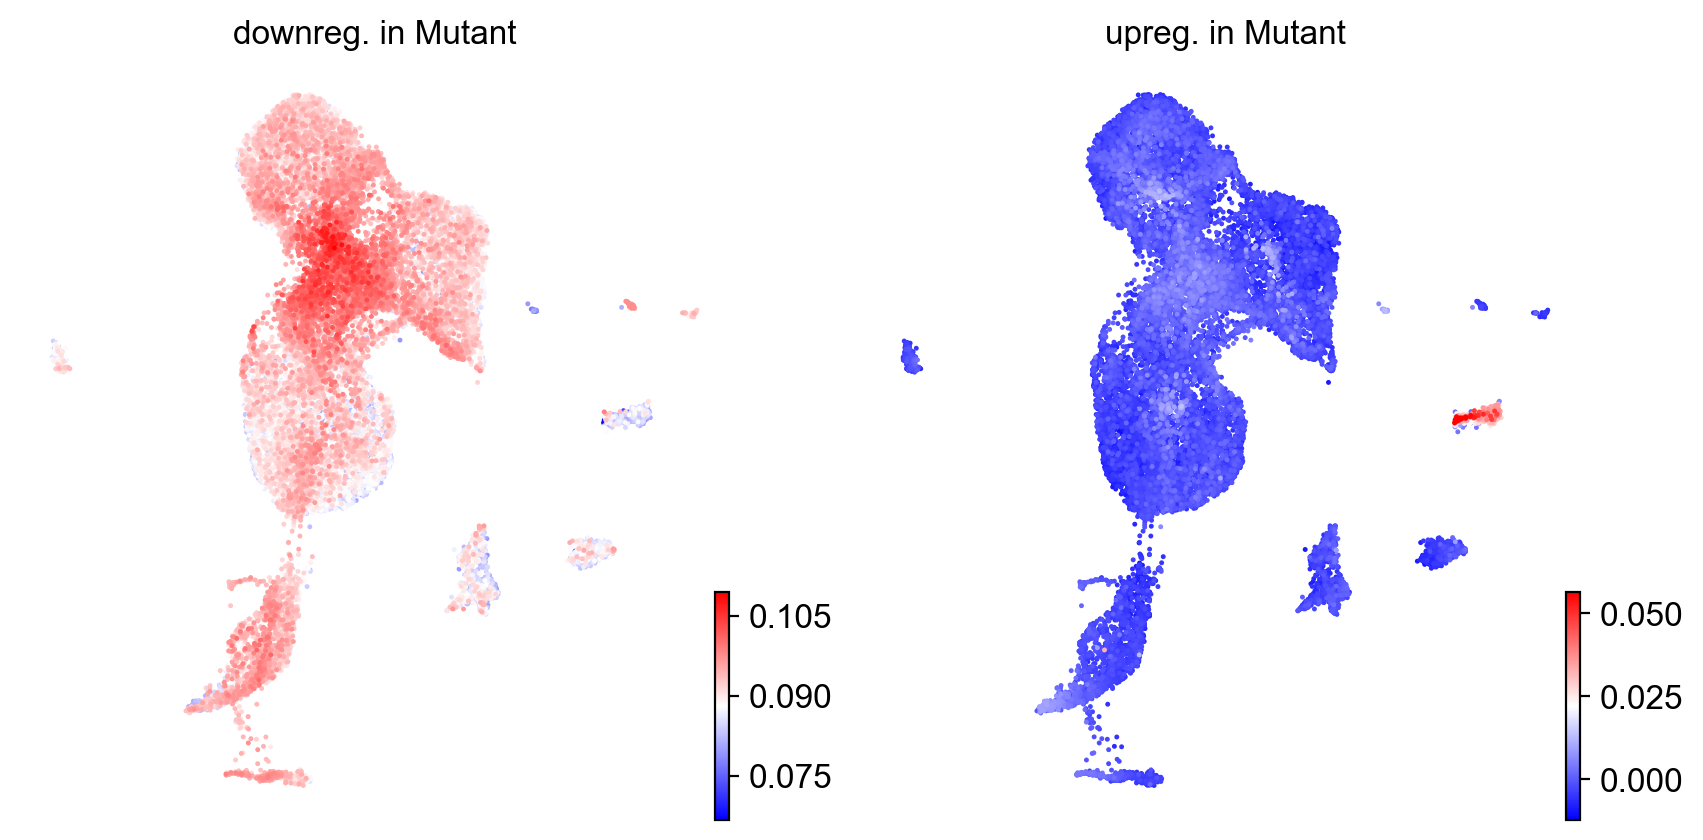

In [31]:
scv.set_figure_params(figsize=(5,5))
sc.tl.score_genes(adata,gene_list=M,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [32]:
sc.tl.rank_genes_groups(adata,"leiden")

In [33]:
sc.get.rank_genes_groups_df(adata,"6").set_index("names").loc["Cdkn1c"]

scores            1.877043e+01
logfoldchanges    4.054559e-01
pvals             4.724148e-75
pvals_adj         1.378998e-73
Name: Cdkn1c, dtype: float64

In [34]:
DE_all=sc.get.rank_genes_groups_df(adata,["2","5","6","3"],pval_cutoff=0.05,log2fc_min=.4).set_index("names")
DE_all=DE_all.loc[DE_all.index.isin(DE_res.index)]
DE_all=DE_all.loc[DE_all.index]
DE_all=DE_all.sort_values("logfoldchanges")
DE_all=DE_all.reset_index()
DE_all=DE_all.drop_duplicates("names",keep="first").set_index("names")

In [35]:
DE_res["leiden"]=np.nan
DE_res.loc[DE_all.index,"leiden"]=DE_all.group

In [36]:
DE_res

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
Geneid                                                                    
Gjb2      1979.567428        3.172278  0.439709  7.214489  5.413701e-13   
Adcy8       62.977115        3.168130  0.966628  3.277505  1.047288e-03   
Tlx1        41.793439        3.060296  0.338729  9.034650  1.645283e-19   
Gjb6       726.914608        2.976166  0.512876  5.802892  6.518075e-09   
Mfap5       27.757733        2.720252  0.433447  6.275852  3.477257e-10   
...               ...             ...       ...       ...           ...   
Cnot1    17162.353932       -0.172586  0.051841 -3.329120  8.712071e-04   
Sdha     11284.494635       -0.171910  0.052532 -3.272506  1.065987e-03   
Chd8      8744.238676       -0.171033  0.056318 -3.036884  2.390375e-03   
Vgll4     7135.605217        0.164201  0.052714  3.114950  1.839762e-03   
Marchf6  10016.563789       -0.159764  0.046848 -3.410280  6.489629e-04   

                 padj leiden  
Geneid                        
Gjb2     3.570218e-10      6  
Adcy8    2.720079e-02    NaN  
Tlx1     2.772851e-16    NaN  
Gjb6     1.432843e-06      2  
Mfap5    1.034187e-07      2  
...               ...    ...  
Cnot1    2.380986e-02    NaN  
Sdha     2.738535e-02    NaN  
Chd8     4.595337e-02    NaN  
Vgll4    3.899900e-02      6  
Marchf6  1.904592e-02    NaN  

[832 rows x 7 columns]

In [37]:
tfs=pd.read_csv("mm_mgi_tfs.txt",header=None)[0].values

In [38]:
DE_res["TF"]=False
DE_res.loc[DE_res.index.isin(tfs),"TF"]=True

In [39]:
DE_res2=DE_res.loc[~DE_res.leiden.isna()]

In [40]:
CC_res=DE_res2.loc[(DE_res2.log2FoldChange>0)]
M_res=DE_res2.loc[(DE_res2.log2FoldChange<0)]

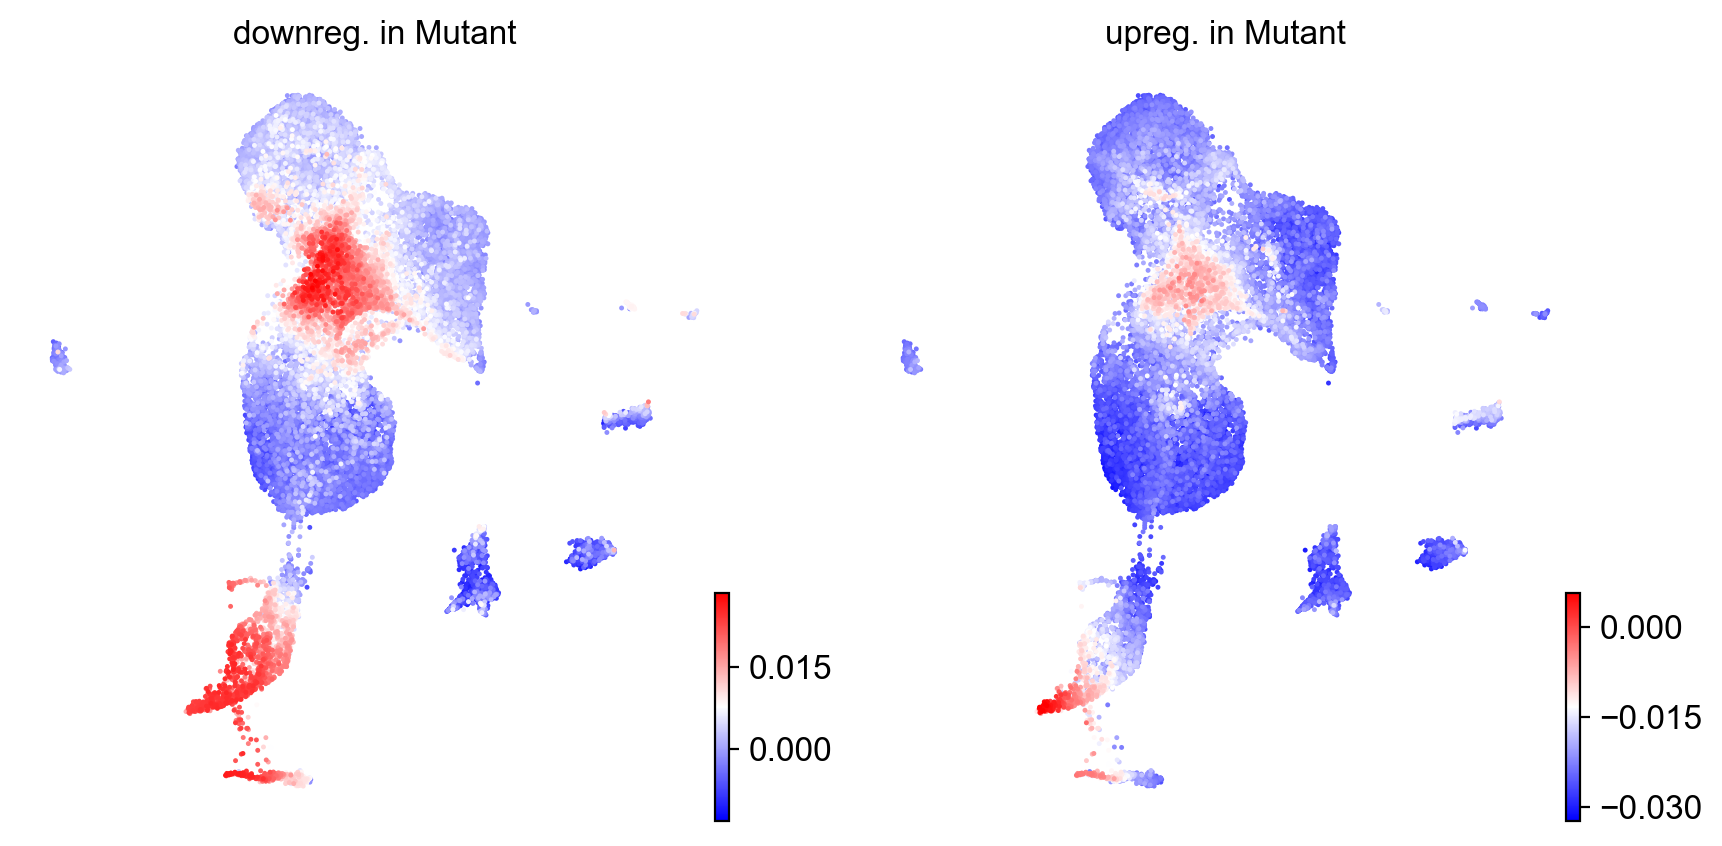

In [41]:
scv.set_figure_params(figsize=(5,5))
sc.tl.score_genes(adata,gene_list=M_res.index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res.index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [42]:
CC_res

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
Geneid                                                                     
Gjb2     1979.567428        3.172278  0.439709   7.214489   5.413701e-13   
Gjb6      726.914608        2.976166  0.512876   5.802892   6.518075e-09   
Mfap5      27.757733        2.720252  0.433447   6.275852   3.477257e-10   
Pbx1     9676.891394        2.156725  0.076159  28.318841  2.025943e-176   
Krt15    1791.154733        2.087818  0.358966   5.816203   6.019947e-09   
...              ...             ...       ...        ...            ...   
H1f0    25776.766676        0.199640  0.054640   3.653755   2.584332e-04   
Isl1     2050.974543        0.198783  0.063775   3.116950   1.827327e-03   
Trib2    3827.711417        0.188802  0.062874   3.002855   2.674597e-03   
Lmo4     8689.315380        0.173779  0.057704   3.011544   2.599225e-03   
Vgll4    7135.605217        0.164201  0.052714   3.114950   1.839762e-03   

                 padj leiden     TF  
Geneid                               
Gjb2     3.570218e-10      6  False  
Gjb6     1.432843e-06      2  False  
Mfap5    1.034187e-07      2  False  
Pbx1    3.072950e-172      6   True  
Krt15    1.342802e-06      2  False  
...               ...    ...    ...  
H1f0     1.005106e-02      3  False  
Isl1     3.898298e-02      5   True  
Trib2    4.919256e-02      3  False  
Lmo4     4.837429e-02      6  False  
Vgll4    3.899900e-02      6  False  

[211 rows x 8 columns]

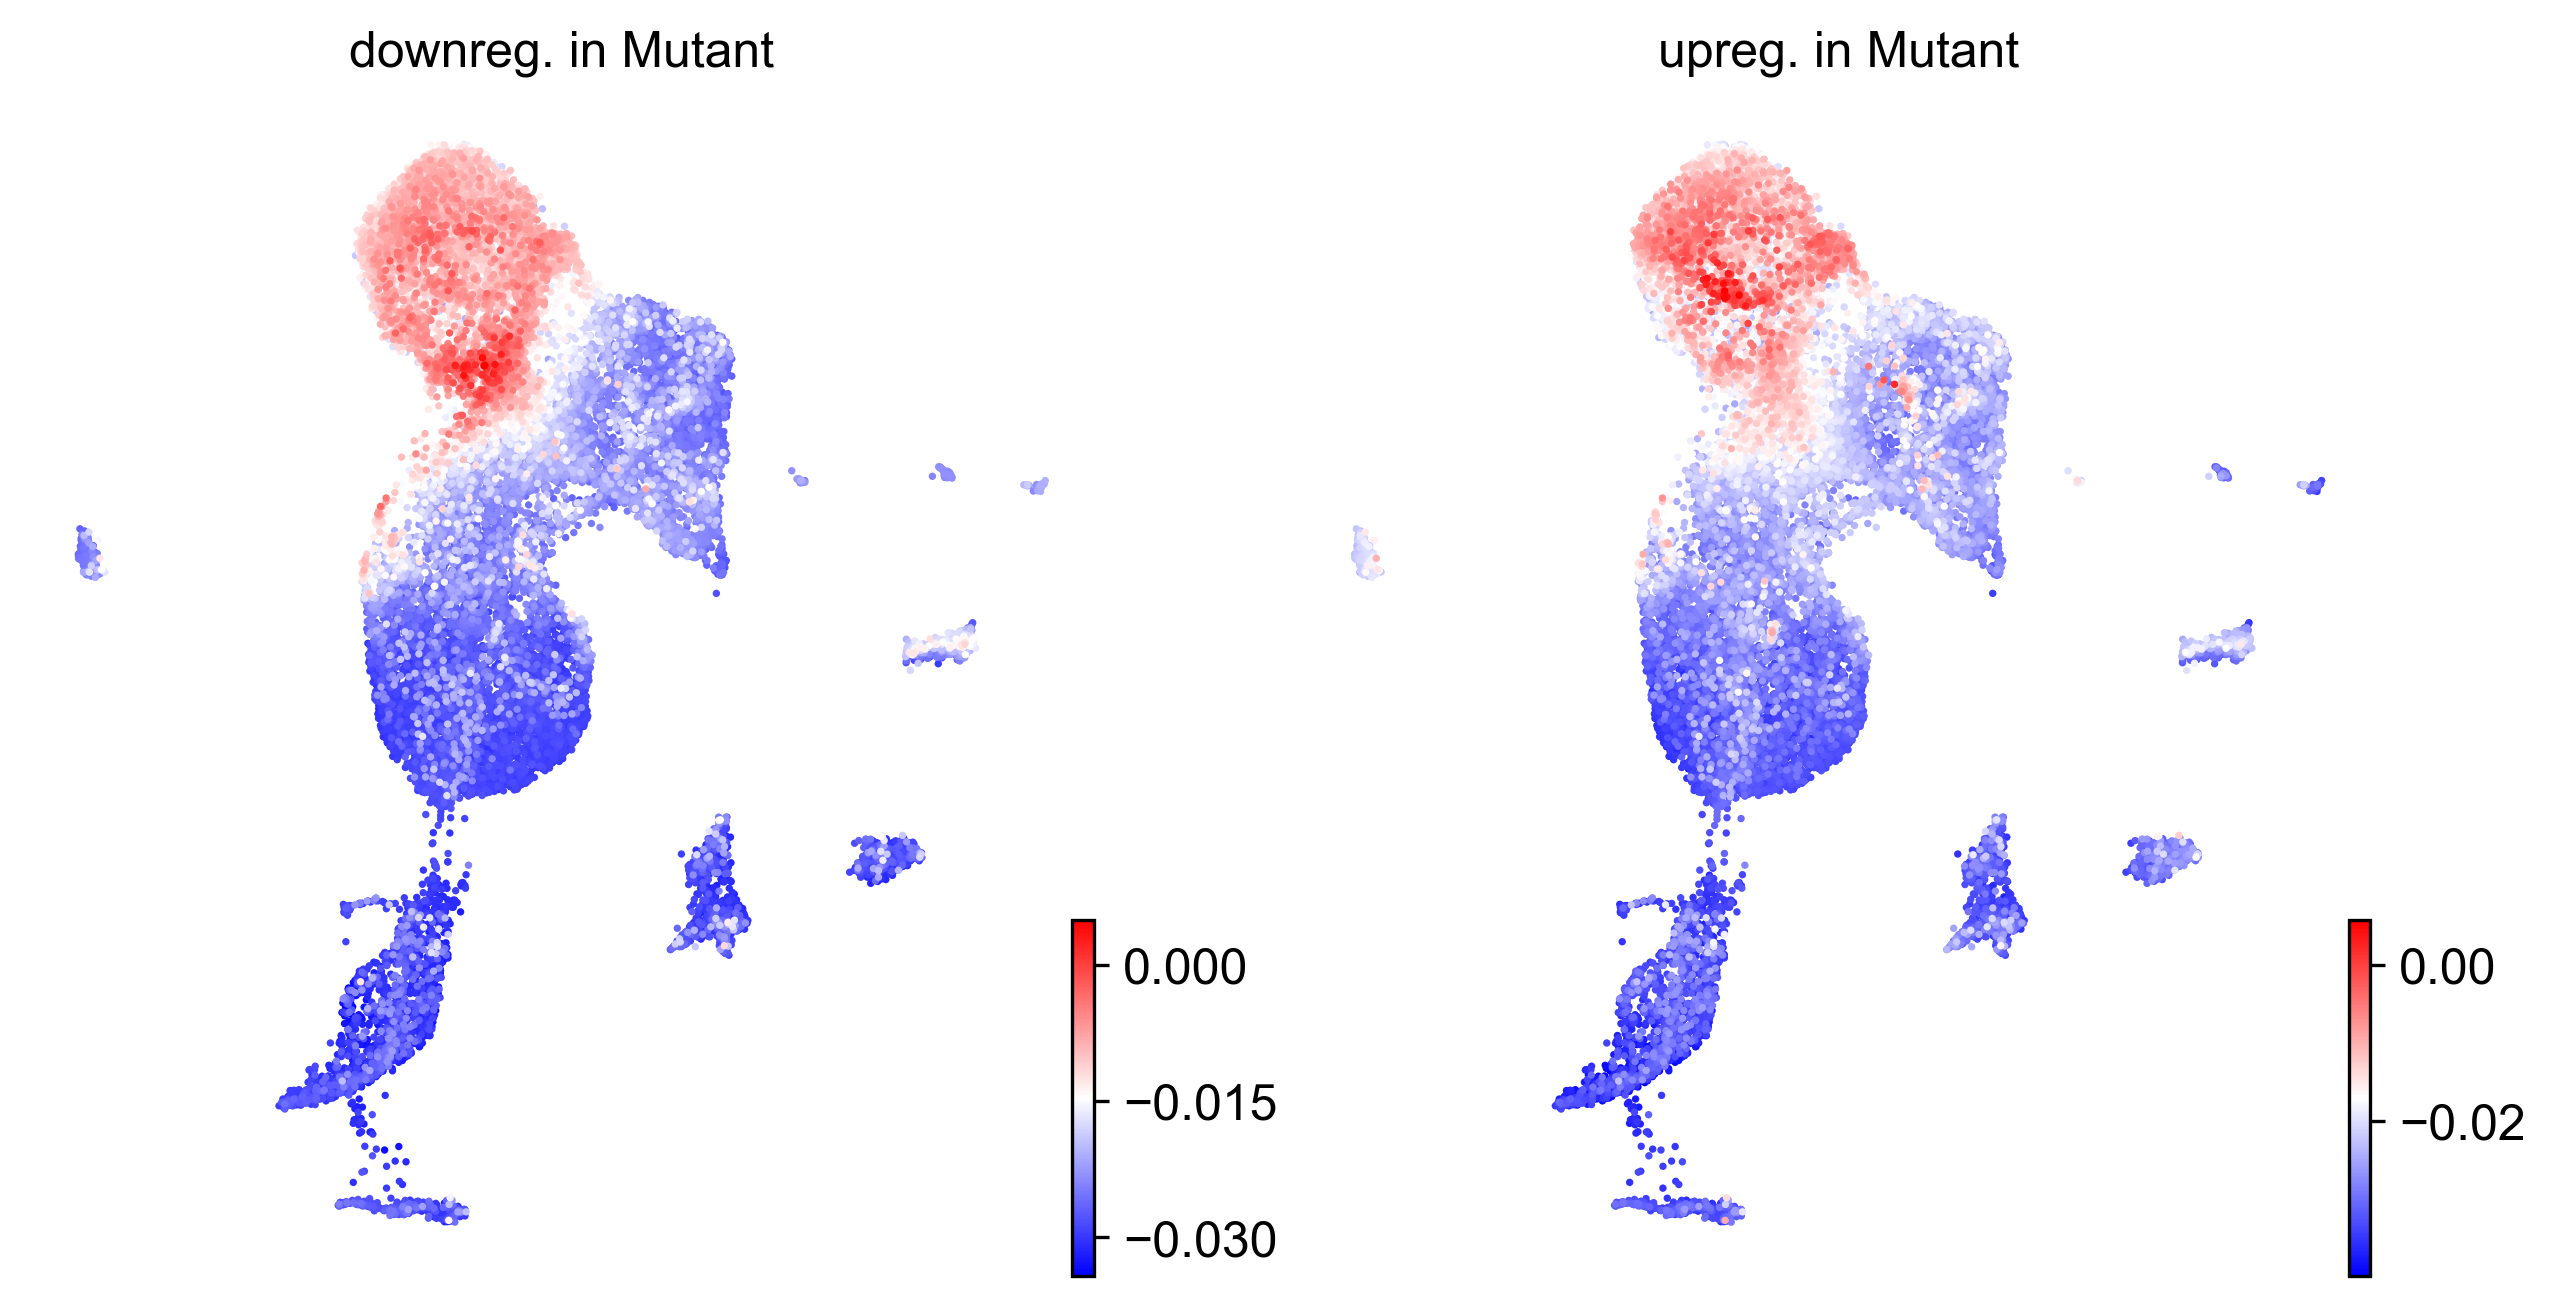

In [43]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="2"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="2"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [44]:
print(f"{CC_res[(CC_res.leiden=='2')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="2") & (CC_res.TF)].index.tolist()))

79 genes, including: 

Irx6
Hoxc13
Osr2
Arg1
Barx2
Vdr
Irx4
Bnc1
Lmx1b
Tfap2c
Msx2
Zbtb34


In [45]:
print(f"{M_res[(M_res.leiden=='2')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="2") & (M_res.TF)].index.tolist()))

55 genes, including: 

Hmx1
Nr2f2
Nr2f1
Meis2


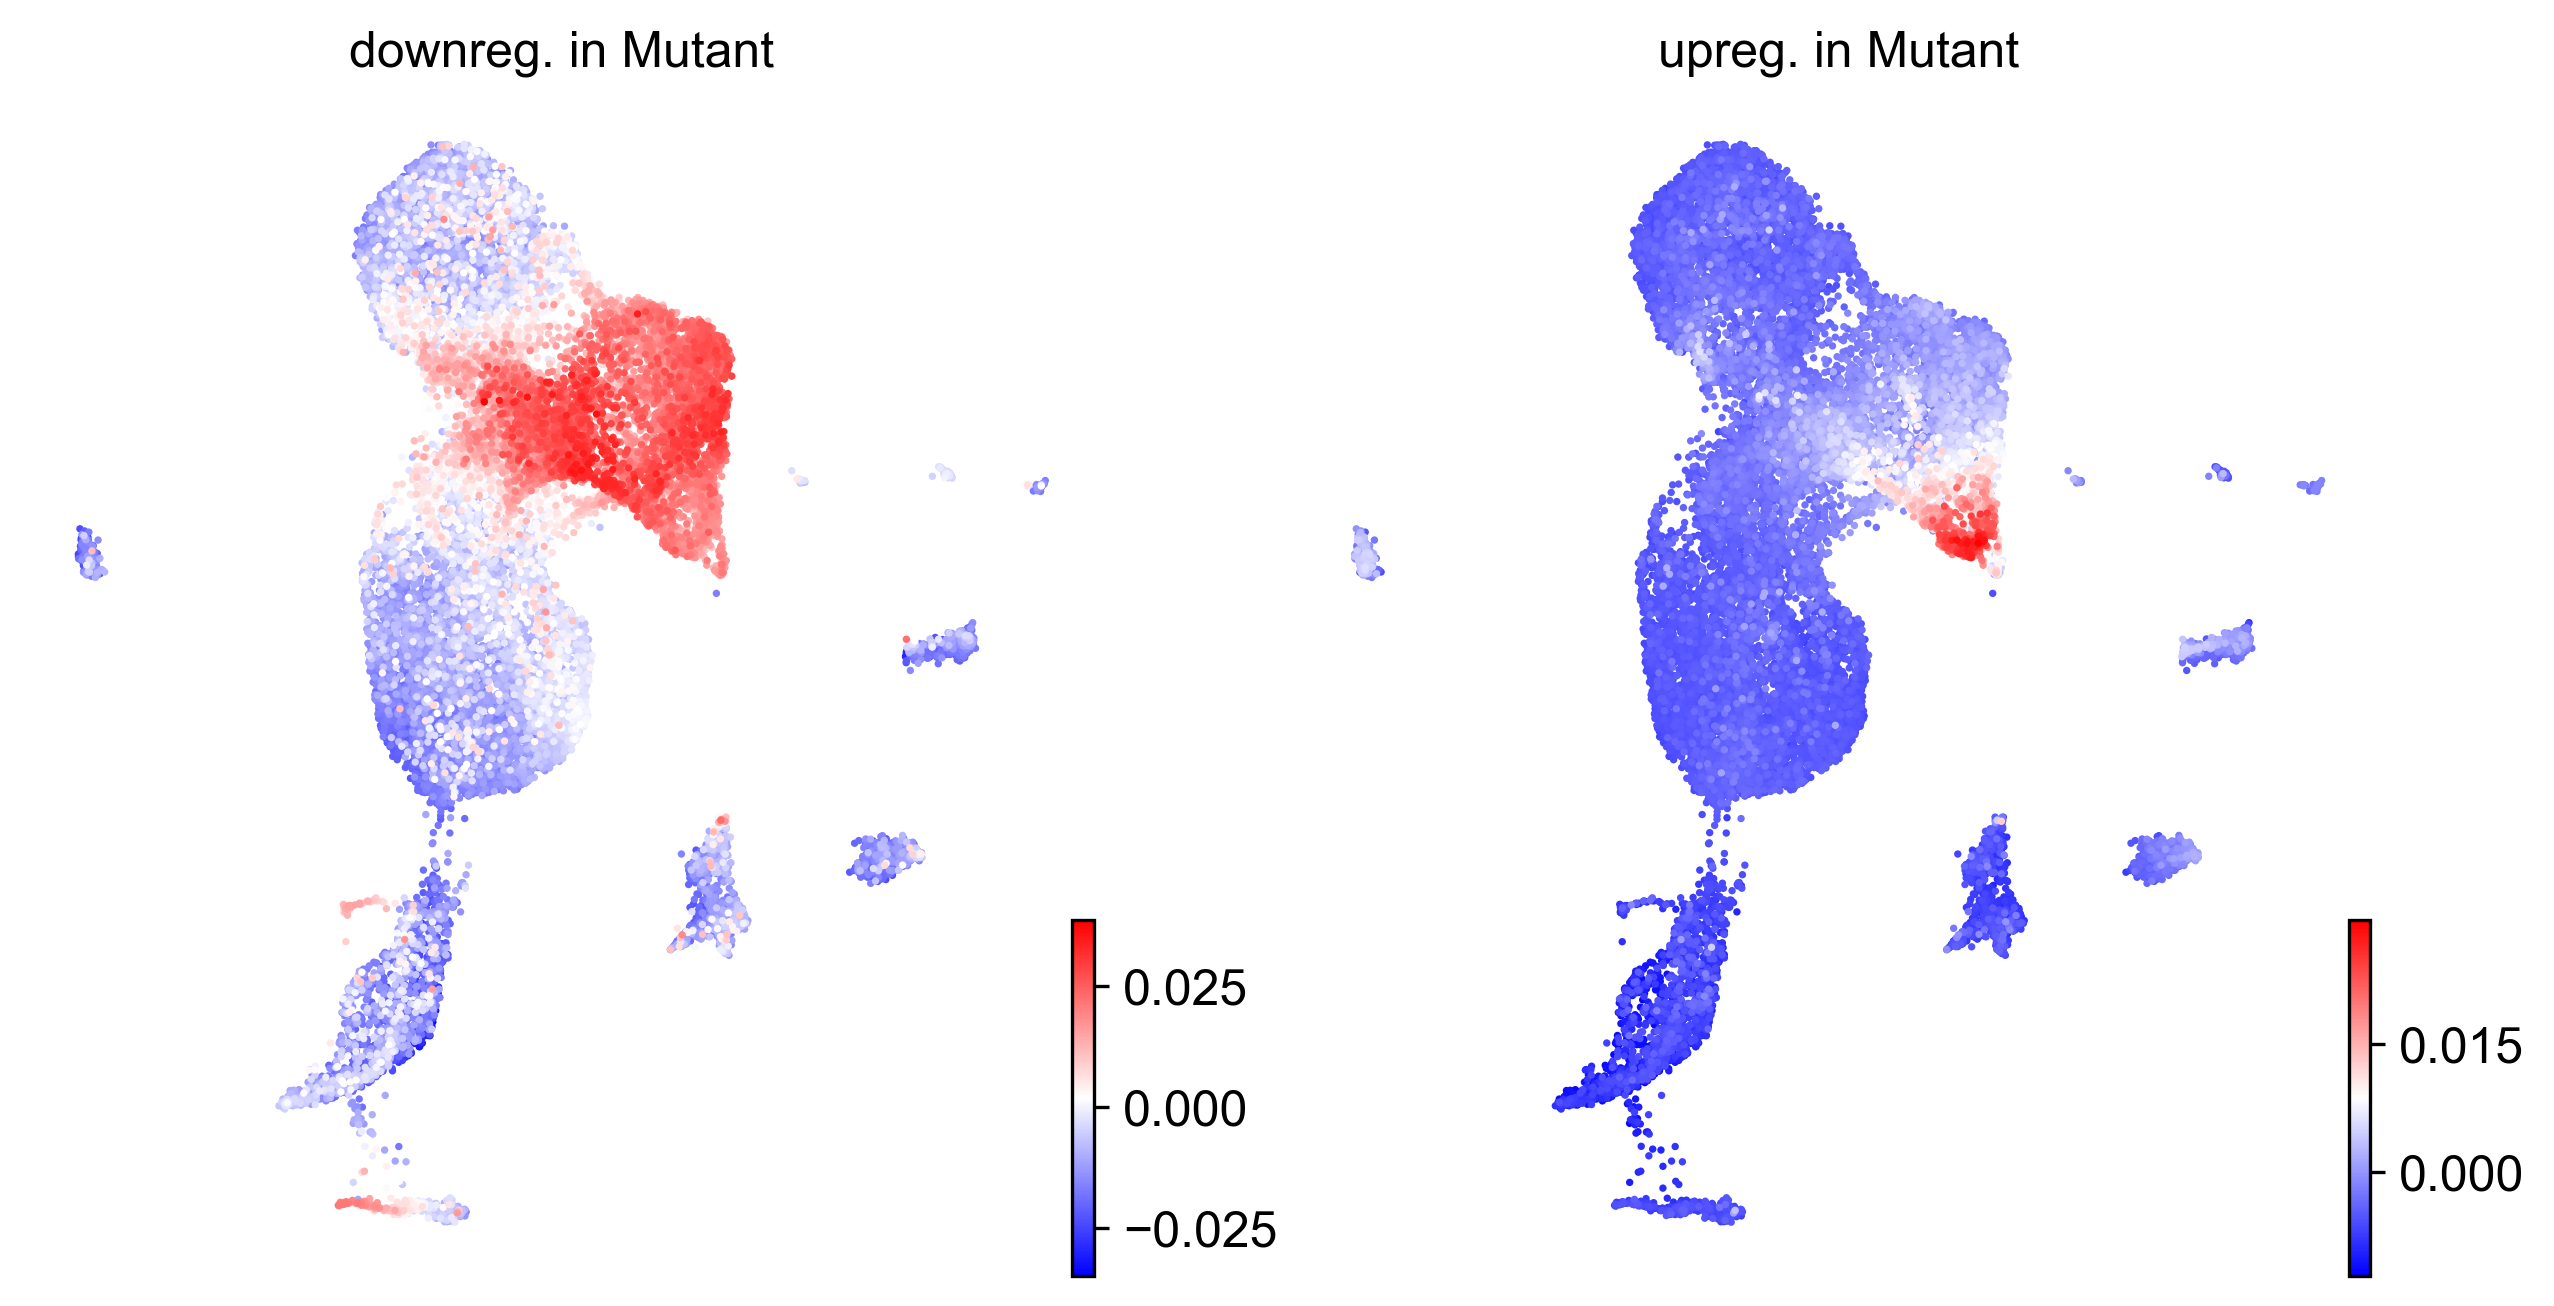

In [46]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="5"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="5"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [47]:
print(f"{CC_res[(CC_res.leiden=='5')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="5") & (CC_res.TF)].index.tolist()))

26 genes, including: 

Dmrt2
Isl2
Gli1
Isl1


In [48]:
print(f"{M_res[(M_res.leiden=='5')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="5") & (M_res.TF)].index.tolist()))

36 genes, including: 

Creb3l2


In [49]:
#scv.set_figure_params(figsize=(3,5.2),dpi=150)
#sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="1"].index,score_name="upreg. in Mutant")
#sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="1"].index,score_name="downreg. in Mutant")
#scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

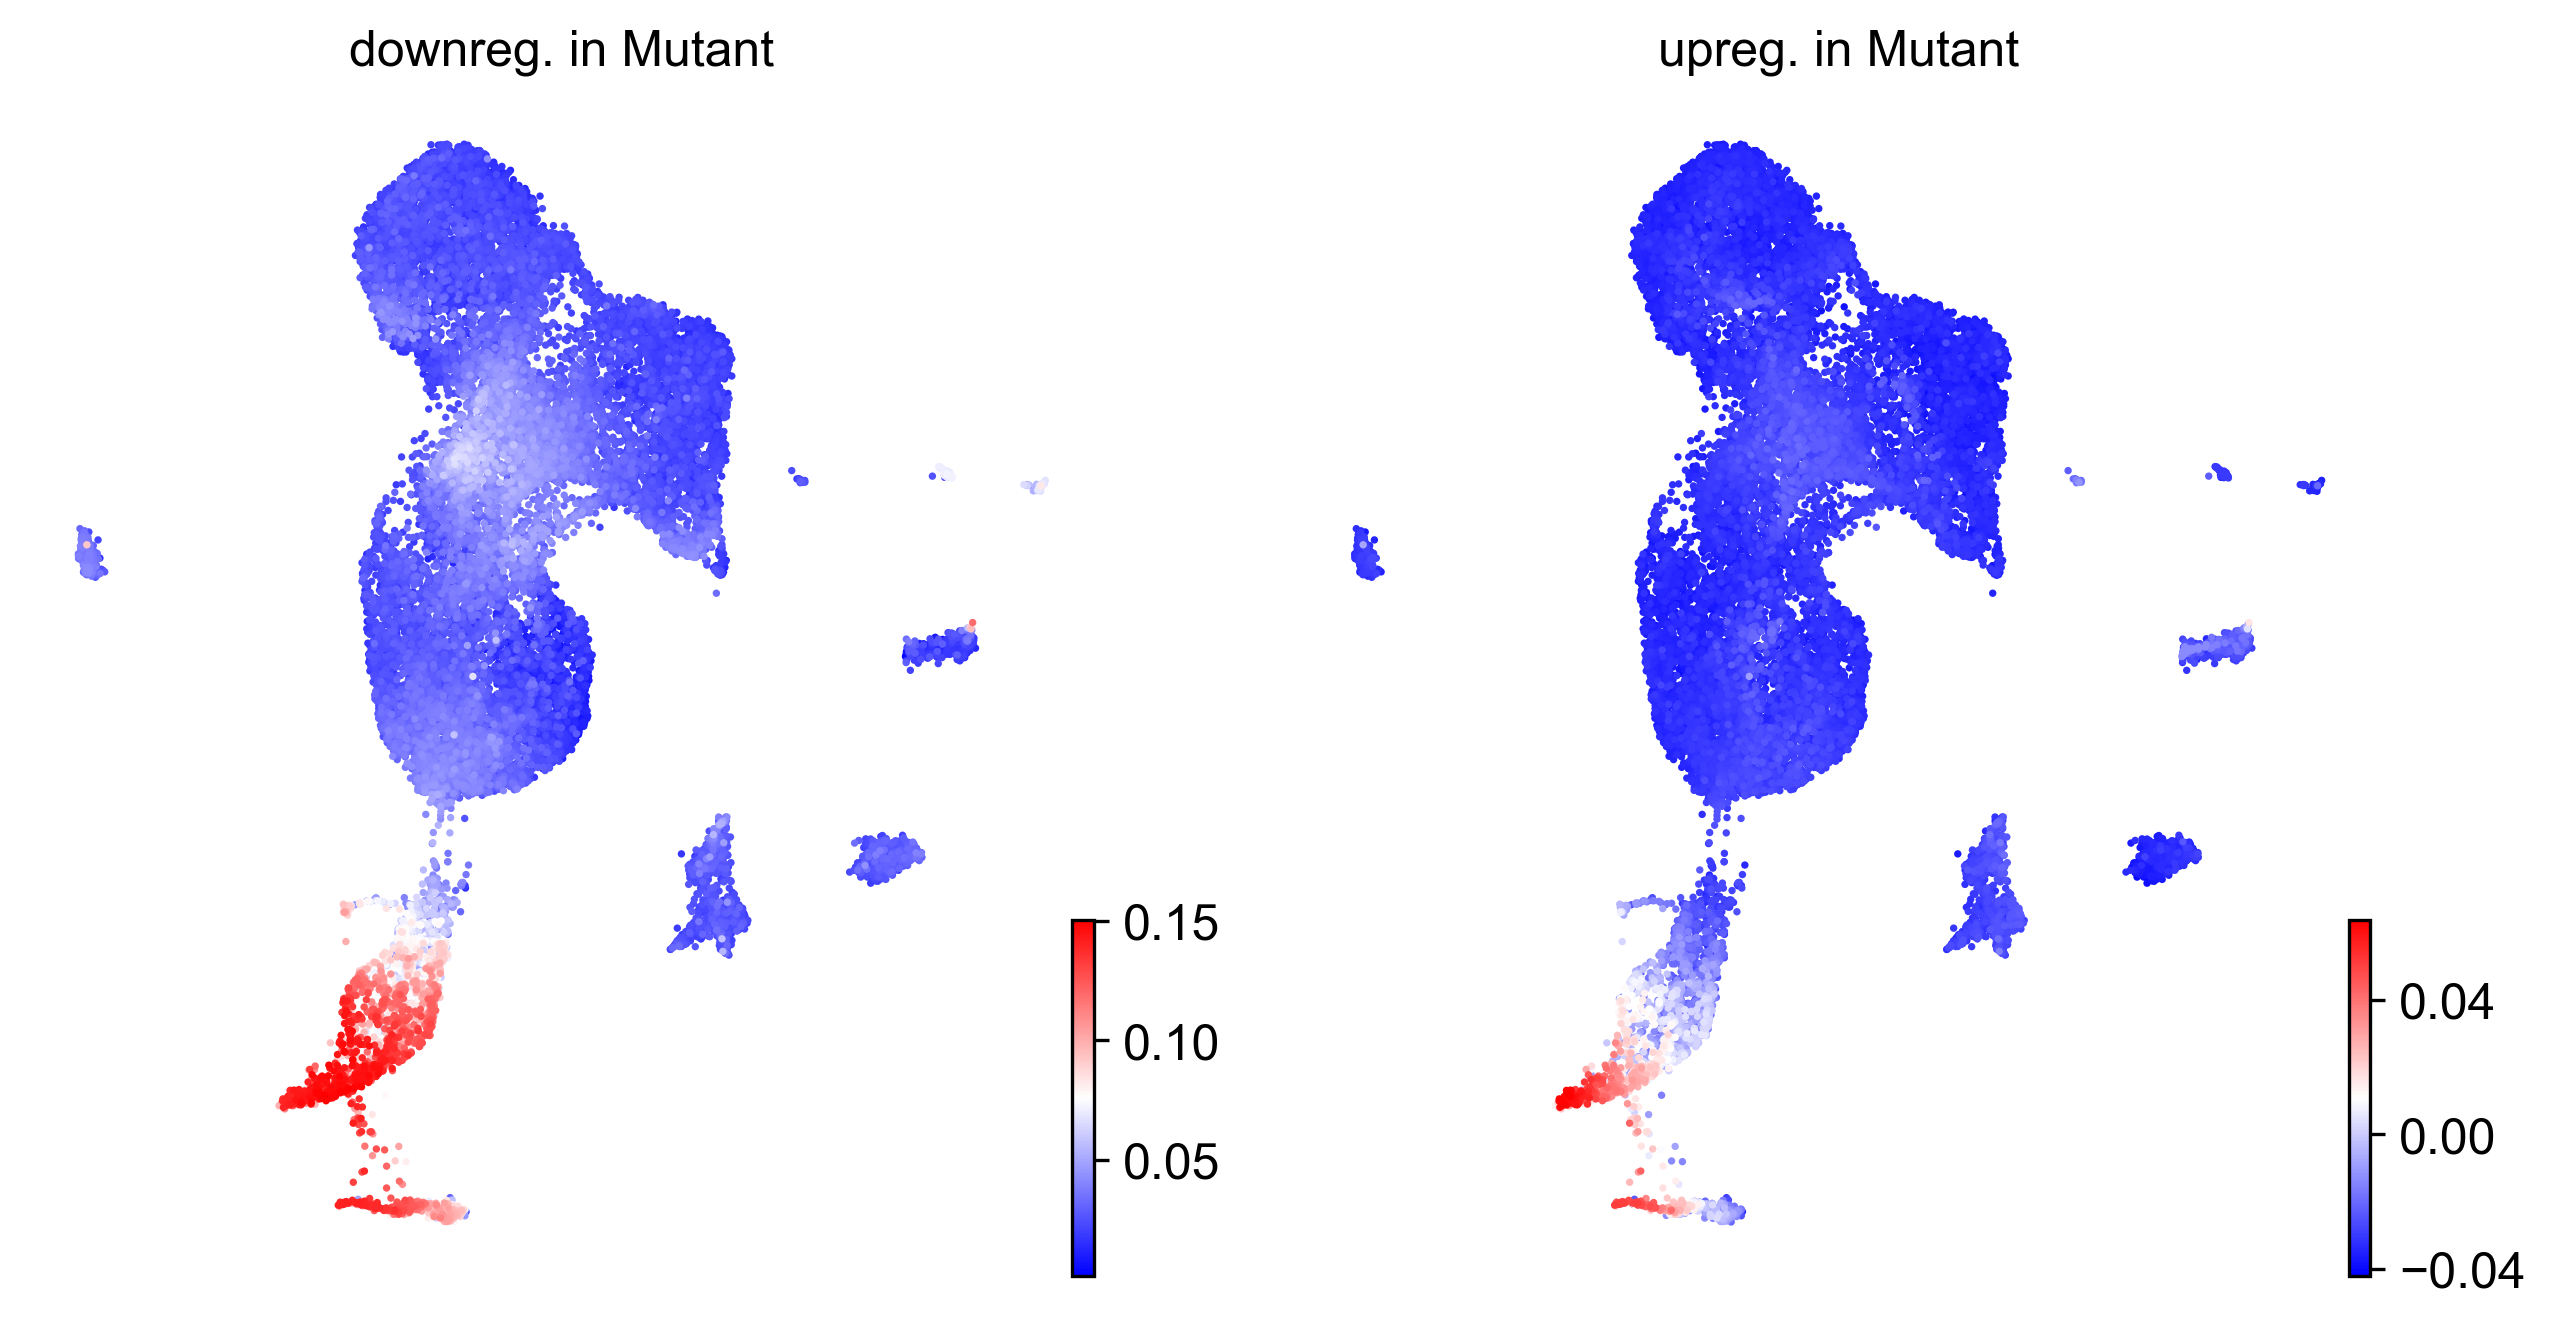

In [50]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="3"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="3"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [51]:
print(f"{CC_res[(CC_res.leiden=='3')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="3") & (CC_res.TF)].index.tolist()))

49 genes, including: 

Lhx3
Fezf2


In [52]:
print(f"{M_res[(M_res.leiden=='3')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="3") & (M_res.TF)].index.tolist()))

58 genes, including: 

Prox1


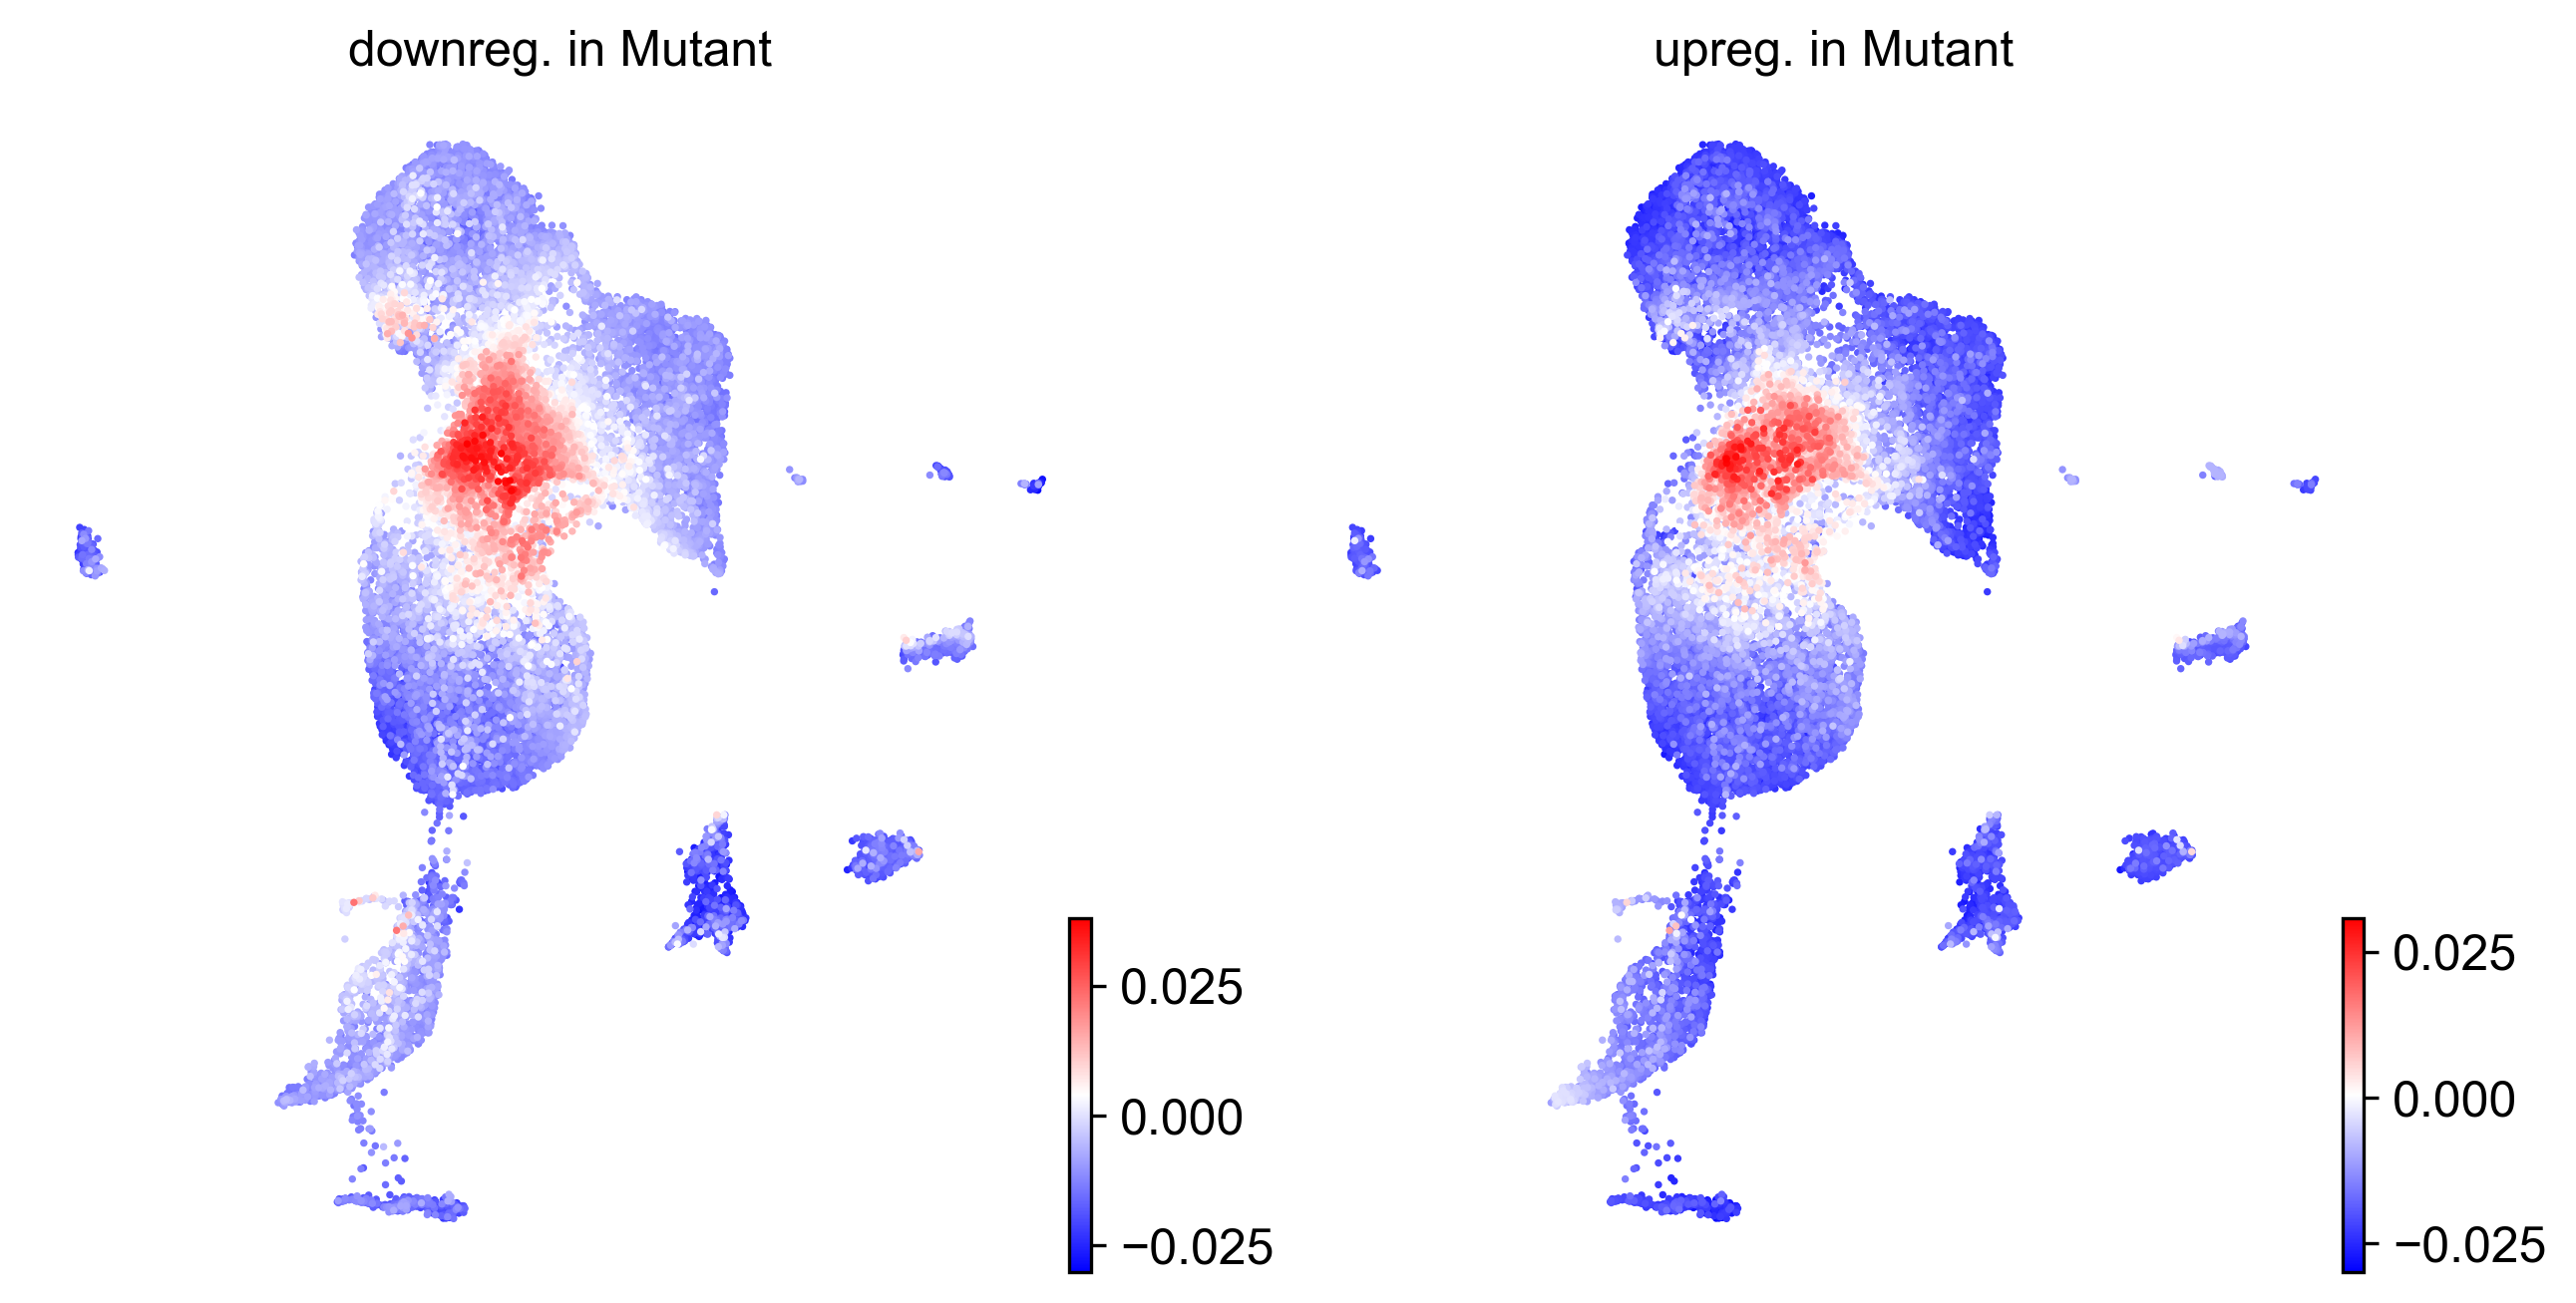

In [53]:
scv.set_figure_params(figsize=(5,5.2),dpi=150)
sc.tl.score_genes(adata,gene_list=M_res[M_res.leiden=="6"].index,score_name="upreg. in Mutant")
sc.tl.score_genes(adata,gene_list=CC_res[CC_res.leiden=="6"].index,score_name="downreg. in Mutant")
scv.pl.umap(adata,color=["downreg. in Mutant","upreg. in Mutant"],cmap="bwr",smooth=True)

In [54]:
print(f"{CC_res[(CC_res.leiden=='6')].shape[0]} genes, including: \n")
print("\n".join(CC_res[(CC_res.leiden=="6") & (CC_res.TF)].index.tolist()))

57 genes, including: 

Pbx1
Fosl2
Junb
Otx1
Smad7
Id1
Esrra
Tgif1


In [55]:
print(f"{M_res[(M_res.leiden=='6')].shape[0]} genes, including: \n")
print("\n".join(M_res[(M_res.leiden=="6") & (M_res.TF)].index.tolist()))

42 genes, including: 

Foxo1
Sox5
Id4
Foxo3


In [56]:
DE_final=pd.concat([M_res,CC_res.iloc[::-1]])
DE_final.log2FoldChange=-DE_final.log2FoldChange
DE_final.to_csv("filtered_DE.csv")

In [57]:
print("\n".join(M_res[M_res.leiden=="6"].index))

Aqp3
Jph2
Igfbp3
Rgs2
Dapk2
Stk32a
Gdf6
Parvb
Arhgef6
Fgf10
Camk1d
Sema6d
Lhfp
Tns4
Spry4
Rdh10
Cpm
Sgk1
Fut4
Nrip1
Gja1
Foxo1
Slc39a14
Arhgef28
Khdrbs3
Pik3r1
Sox5
Wdr19
Id4
Dpysl3
Klhl5
Tbc1d9
Samd5
Zfhx4
Igfbp4
Foxo3
Prrg3
Tle4
St6gal1
Itga6
Rmnd5a
Rnf150


In [58]:
print("\n".join(CC_res[CC_res.leiden=="6"].index))

Gjb2
Pbx1
Ptger4
Artn
Dapl1
Unc13c
Nipal2
2610035D17Rik
H2-T23
Krt19
Crtac1
Adamts18
Diras2
Prickle1
Ankrd22
Fosl2
Itgb6
Zfp385c
Has2
Smpdl3a
Fam162a
Ppp2r2b
Kif26a
Junb
Slc4a3
Dpp7
Cnksr1
Plekhn1
Cdkn1c
Smim20
Wdr45
Gad2
Sema3c
Otx1
Erich1
Smad7
Plxna2
Bnip3
Bnipl
Ntm
Id1
Rapgefl1
Efna1
Ier5
Btg1
Fgd2
Esrra
Ern1
Ankzf1
Tgif1
Mpped2
Mfap4
Ddit4
Pdgfc
Ypel1
Lmo4
Vgll4


In [59]:
print("\n".join(M_res[M_res.leiden=="2"].index))

Hapln1
Hmx1
Ccbe1
Steap3
Abcg5
Gm26688
Ccdc80
Wif1
Padi3
Angpt1
Ror1
Lama1
Cyp1b1
Art4
Nr2f2
Nr2f1
Serpinb6b
Arsi
Pde5a
Vgll3
Clic6
Kank4
Ttc39a
Ass1
Slit3
Vsir
Col8a2
Capn1
Necab1
Cyp26a1
Enpp1
Ptges
Nudt11
Frem2
Pros1
Fgfr3
Tgfbi
Prkce
Rbpms
Efna5
Egfl6
Tuft1
Col5a2
Gas7
Fat2
Dock4
Dock11
Gprc5c
Thbs1
Antxr1
Dnajc1
Cdh3
Prkci
Xpr1
Meis2


In [60]:
print("\n".join(CC_res[CC_res.leiden=="2"].index))

Gjb6
Mfap5
Krt15
Gabra1
Ppp1r1b
Col12a1
Irx6
Cd36
Hoxc13
Kcnj2
Sphkap
Chrm3
Osr2
Rab7b
Lgals7
Fgd5
Timp3
Cdh13
Arg1
Lpar3
Fam83c
Bmp6
Lgi2
Smagp
Piezo2
Ngf
Lrrtm1
Scnn1g
Etaa1os
Astn2
C130021I20Rik
Pla2r1
Slc35b3
Dlk2
Plxna4
Man1a
Barx2
Gimap9
Vdr
Slc7a10
Irx4
Tmem132c
Ccdc3
Aass
Rab29
Wnt3
Zcchc12
Lrp8os2
Exoc3l4
Krt1
Cryl1
Siah2
Gabrp
Plbd1
Avpi1
Wnt9b
Bnc1
St6gal2
Wnt4
Lmx1b
Gk
Tfap2c
Col4a6
Sema3a
Dock8
Inafm1
Pwwp2b
Wnt10a
Acpp
Nav2
Hras
Msx2
Ap4s1
Pdpn
Pdlim1
Col4a5
Tmem123
Ctsl
Zbtb34


In [61]:
print("\n".join(CC_res[CC_res.leiden=="5"].index))

Mgp
Rgs5
Sema3d
Chst2
Pde7b
Icam1
Dmrt2
Zfyve28
Isl2
Il1r1
Gli1
Lifr
Hspb1
Shh
Anxa2
Plxnc1
Atox1
Cox4i2
Cldn8
Baiap2
Ube2e2
Meg3
Vcan
Col11a1
Aprt
Isl1


In [62]:
DE_final

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
Geneid                                                                     
Gdnf      108.828221        1.618875  0.287706  -5.626839   1.835417e-08   
Hapln1   4004.107885        1.573818  0.135015 -11.656582   2.123991e-31   
Slc26a7    80.363414        1.338431  0.211885  -6.316775   2.670773e-10   
Atp1a2     72.260621        1.203457  0.222608  -5.406174   6.438510e-08   
Gfra2     314.088417        1.131976  0.163942  -6.904735   5.029723e-12   
...              ...             ...       ...        ...            ...   
Krt15    1791.154733       -2.087818  0.358966   5.816203   6.019947e-09   
Pbx1     9676.891394       -2.156725  0.076159  28.318841  2.025943e-176   
Mfap5      27.757733       -2.720252  0.433447   6.275852   3.477257e-10   
Gjb6      726.914608       -2.976166  0.512876   5.802892   6.518075e-09   
Gjb2     1979.567428       -3.172278  0.439709   7.214489   5.413701e-13   

                  padj leiden     TF  
Geneid                                
Gdnf      3.663105e-06      5  False  
Hapln1    8.054173e-28      2  False  
Slc26a7   8.267406e-08      5  False  
Atp1a2    1.085103e-05      5  False  
Gfra2     2.460995e-09      3  False  
...                ...    ...    ...  
Krt15     1.342802e-06      2  False  
Pbx1     3.072950e-172      6   True  
Mfap5     1.034187e-07      2  False  
Gjb6      1.432843e-06      2  False  
Gjb2      3.570218e-10      6  False  

[402 rows x 8 columns]

In [63]:
DE_res=DE_res.sort_values("log2FoldChange")

In [64]:
DE_res.log2FoldChange=-DE_res.log2FoldChange

In [65]:
DE_res.to_csv("unfiltered_DE.csv")